# To analyze and classify the sarcoma dataset
* note that some classifiers may require using a computer cluster due to memory requirements
* These package versions were used for the manuscript: scikit-learn v1.3.2, catboost v1.2.3, xgboost v2.0.3, lightgbm v4.3.0, joblib v1.3.2, optuna v3.5.0, numpy v1.23.4, pandas v2.0.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import copy
#import chart_studio.plotly as py
#import plotly.express as px
#import plotly.graph_objects as go
#from matplotlib import colors
import os
import json
import sys
from numpy import ma
import seaborn as sns
import logging
#pd.set_option('display.max_columns',200)
#import plotnine as p9
#from plotnine import *
#from plotnine.data import *

from scipy import stats
from scipy.stats import zscore
#from natsort import natsorted
from glob import glob
import glob
from statistics import mean
#import shutil
import random
import copy
#from scipy.stats import shapiro, skew

#import lime
#import lime.lime_tabular

#logger = logging.getLogger(__name__)
#logger.setLevel(logging.INFO)
#logging.basicConfig()

import joblib

#import sklearn.datasets

#from sklearn.preprocessing import FunctionTransformer
#from sklearn.metrics import plot_roc_curve
#from sklearn.inspection import plot_partial_dependence, permutation_importance
#from sklearn.metrics import RocCurveDisplay, plot_confusion_matrix, plot_precision_recall_curve, roc_curve

#import PipelineProfiler
from joblib import dump, load
import scikitplot as skplt
#from sklearn.metrics import classification_report
import optuna
import scipy.stats as stats
import math
import random
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from scipy.stats import shapiro, skew
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV, RFE, SelectKBest, chi2
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, ElasticNetCV, LassoLarsCV, ElasticNet, LogisticRegression
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score, mean_absolute_error, cohen_kappa_score, make_scorer
from sklearn.metrics import classification_report, roc_auc_score, auc, RocCurveDisplay, roc_curve
import sklearn.model_selection
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC, LinearSVC

# Hide warnings 
import warnings
warnings.filterwarnings("ignore")
#plotly_template = 'simple_white'

In [2]:
# set working directory

os.chdir('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls')

In [3]:
# make some lists to fill later

dfTrainModelEvalAllSeeds = pd.DataFrame()
seedListStats = []
trainFracListStats = []
finalClassifierList = []
tunedClassifierListForValidation = []
finalImportancesMeanList = []
finalFeaturesList = []

y_testList = []
y_predList = []
y_probList = []
seedList = []
seedListStats = []
trainFracListStats = []

In [4]:
# key parameters

# adjust based on whether classifying cancer or drug sensitivity
target = 'sensitivity' # 'sensitivity', 'cancer',

seed = 7 # use seeds 1-7 for each classification to randomize 7 times
np.random.seed(7) # match the seed value

quantType = 'Intensity_Raw' # 'Intensity_Raw', 'areaHarmonized', 'NormalizedIntensity_Log2'
trainFrac = .75
nJobs = 6

if target ==  'sensitivity':
    nSamplesVal = 30
if target ==  'cancer':
    nSamplesVal = 35

In [5]:
# This function takes a dataframe and a target variable to create an X (predictors) dataframe and a y Series

def X_y_split(df, target):
    
    categorical_features = []
    continuous_features = []
    binary_features = []
    
    for col in df.columns:
        if df[col].dtype == object:
            categorical_features.append(col)
        
        else:
            if df[col].nunique() <= 2:
                binary_features.append(col)
            else:
                continuous_features.append(col)
                
    if categorical_features: # if this list isn't empty
        if target in categorical_features:
            categorical_features.remove(target)
        df.drop(categorical_features, axis = 1, inplace = True)

    X, y = df.drop([target], axis = 1), df[target]
    
    return X, y

In [6]:
# This function parses columns by type.

def columns_catNumOrBin(df):

    categorical_features = []
    continuous_features = []
    binary_features = []
    
    for col in df.columns:
        if df[col].dtype == object:
            categorical_features.append(col)
        else:
            if df[col].nunique() <= 2:
                binary_features.append(col)
            else:
                continuous_features.append(col)
    
    return categorical_features,continuous_features, binary_features

In [7]:
# impute 0s

def imputeWideDFMinOr0(df):
    
    for col in df.columns:

        if df[col].dtype == object:
            continue
        
        else:
        
            if quantType == 'NormalizedIntensity_Log2':
                df[col].fillna(value = df[col].min(), inplace = True)
            
            if quantType == 'Intensity_Raw':
                df[col].fillna(value = df[col].min(), inplace = True)
    return df

In [8]:
# load sarcoma cohort results
# use ProteinQuantitationWithSampleMetadata.xlsx from the Gitub repo

dfSarcomaRaw = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls/MQ/vanTine_001_90_samples/Protein/Model/Protein_pVals_Final_WithMetaData.xlsx', sheet_name='Sheet1')

In [9]:
def tidyDFSarcomaRawAndChooseQuantType (df, quantType_):

    global quantType
    quantType = quantType_
    
    df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants
    df = df.query("dataType == @quantType")
    
    totalCols = df.columns
    numCols = df._get_numeric_data().columns
    catCols = list(set(totalCols)-set(numCols))
    
    df = pd.melt(df,
        id_vars = catCols,
        value_vars = numCols,
        var_name = 'protAcc',
        value_name="area",
        ignore_index=False, 
        )
    
    #remove rows without areas & duplicates
    df.dropna(subset=['area'], inplace=True)
    df.drop_duplicates(inplace = True)
    
    # add a column
    dataset = 'sarcoma'
    df.insert(loc=1, column='dataset', value=dataset)
    
    return df

In [10]:
# tidy the dataframe

dfSarcoma = tidyDFSarcomaRawAndChooseQuantType(dfSarcomaRaw, quantType)

In [11]:
# make a uniprot df for annotation
# use uniprotAnnotationsForFigure2.xlxs on the Github repor

dfUniprot = pd.read_csv('uniprotDownload.tsv', delimiter = '\t')

dfUniprot = dfUniprot.rename(columns={'Entry' : 'protAcc'})
dfUniprot = dfUniprot.rename(columns={'Gene Names (primary)' : 'geneNamePrimary'})
dfUniprot = dfUniprot.drop(columns=['Length','Entry Name','Organism','Gene Names'])
dfUniprot['protAcc'] = dfUniprot['protAcc'].astype(str)
dfUniprot.drop_duplicates(subset=['protAcc'], inplace = True)
dfUniprot

,protAcc,Reviewed,Protein names,geneNamePrimary
0,A0A0C5B5G6,reviewed,Mitochondrial-derived peptide MOTS-c (Mitochon...,MT-RNR1
1,A0A1B0GTW7,reviewed,Ciliated left-right organizer metallopeptidase...,CIROP
2,A0JNW5,reviewed,Bridge-like lipid transfer protein family memb...,BLTP3B
3,A0JP26,reviewed,POTE ankyrin domain family member B3,POTEB3
4,A0PK11,reviewed,Clarin-2,CLRN2
...,...,...,...,...
20428,Q9H2U6,reviewed,Putative uncharacterized protein encoded by LI...,LINC00597
20429,Q9H379,reviewed,Putative uncharacterized protein PRO3102,NaN
20430,Q9P1C3,reviewed,Putative uncharacterized protein PRO2829,NaN
20431,Q9UFV3,reviewed,Putative uncharacterized protein DKFZp434L187,NaN


In [12]:
# annotate sarcoma df info by merging with dfUniprot

dfSarcoma = dfSarcoma.merge(dfUniprot, on='protAcc', how='left')

totalCols = dfSarcoma.columns
numCols = dfSarcoma._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

dfSarcoma['area'] = dfSarcoma['area'].astype(float) 

### Filter dfSarcoma

In [13]:
# tidy timing

def filterTiming(df):
    if target == 'sensitivity':
        df.query('timing == "Pre"', inplace = True)
    elif target == 'cancer':
        df.query('timing != "Post"', inplace = True)

    return df

In [14]:
dfFiltered = filterTiming(dfSarcoma)

In [16]:
def removeCrapome(df):
    crapome =['KRT1', 'KRT2', 'KRT3', 'KRT4', 'KRT5', 'KRT6', 'KRT7', 'KRT8', 'KRT9', 'KRT10', 'KRT11', 'KRT12', 'KRT13', 'KRT14', 'KRT15', 'KRT16', 'KRT17', 'KRT18', 'KRT19', 'KRT20', 'KRT21', 'KRT22', 'KRT23', 'KRT24']
#    df.loc[~df['geneNamePrimary'].str.contains('|'.join(crapome))]
    df.query('geneNamePrimary not in @crapome', inplace = True)

    return df

In [17]:
dfFiltered = removeCrapome(dfSarcoma)

In [18]:
# count protein IDs

def filterNDetectionsPerProtAcc(df, nSamplesVal_):

    global nSamplesVal
    nSamplesVal = nSamplesVal_
    print(nSamplesVal)
    
    #drop 0 values
    df['area'].replace(0, np.nan, inplace=True)
    df.dropna(subset = ['area'], inplace = True)
    
    # count
    df['nSamples'] = df.groupby('protAcc')['protAcc'].transform('count')
    
    # filter by N detections
    df = df.query('nSamples >= @nSamplesVal')  # variable set above
    
    return df

In [19]:
dfFiltered = filterNDetectionsPerProtAcc(dfFiltered, nSamplesVal)

30


### impute NANs

In [24]:
def imputeDfMinOr0 (df, colToImpute):
    
    if quantType == 'NormalizedIntensity_Log2':
        df[colToImpute].fillna(value = df[colToImpute].min(), inplace = True)
    
    if quantType == 'Intensity_Raw':
        df[colToImpute].fillna(value = df[colToImpute].min(), inplace = True)

    return df

In [25]:
dfFiltered = imputeDfMinOr0(dfFiltered, 'area')

### pivot to wide data

In [26]:
categorical_features,continuous_features, binary_features = columns_catNumOrBin(dfFiltered)

#### Save dfFiltered

In [27]:
# pivot df by geneNamePrimary

indexListTemp = categorical_features.copy()
indexListTemp.remove('geneNamePrimary')
indexListTemp.remove('protAcc')
indexListTemp.remove('Reviewed')
indexListTemp.remove('Protein names')

dfML = pd.pivot(
    dfFiltered,
    values = 'area',
    columns = 'geneNamePrimary',
    index = ['timing','dataset', 'gender', 'sample', 'cancerType', 'dataType', 'patient', 'group', 'age', 'cancer', 'sensitivity', 'race']
).reset_index()

## remove categorical columns

In [28]:
categorical_features,continuous_features, binary_features = columns_catNumOrBin(dfML)

In [29]:
def dfRemoveAllCatColsButTarget(df):
    
    categorical_features = []
    continuous_features = []
    binary_features = []
    
    for col in df.columns:
        if df[col].dtype == object:
            categorical_features.append(col)
        
        else:
            if df[col].nunique() <= 2:
                binary_features.append(col)
            else:
                continuous_features.append(col)
    
    categorical_features.remove(target)
        
    df.drop(categorical_features, axis = 1, inplace = True)
    
    return df

In [30]:
dfML = dfRemoveAllCatColsButTarget(dfML)

### Split dfML into training, validation, and testing datasets prior to any transformation or feature selection.

In [31]:
df = dfML.copy() 

# random splitting into each set
dfTrain = df.groupby(target, group_keys=False).sample(frac=trainFrac, random_state=seed)
dfTest = df[~df.index.isin(dfTrain.index)]

# validation fraction, taken from dfTrain.
valFrac = .20

dfValidation = dfTrain.groupby(target, group_keys=False).sample(frac=valFrac, random_state=seed)
dfTrain= dfTrain[~dfTrain.index.isin(dfValidation.index)]

In [32]:
# save
df = dfML 
df = df.reset_index(drop = True)
df.to_excel('dfTest_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')

df = dfTest
df = df.reset_index(drop = True)
df.to_excel('dfTest_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')

df = dfValidation
df = df.reset_index(drop = True)
df.to_excel('dfValidation_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')

df = dfTrain
df = df.reset_index(drop = True)
df.to_excel('dfTrain_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')

In [33]:
# Split into X and y

X, y = X_y_split(dfTrain, target)

In [34]:
imputeWideDFMinOr0(X)

geneNamePrimary,A1BG,ABCF1,ABI1,ACOT9,ACTA1,ACTB,ACTG1,ACTN1,ACTN4,ACTR2,...,YWHAB,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ,ZC3HAV1,ZDHHC2,ZMPSTE24,ZYX
22,7632000.0,496590.0,2438242.0,291130.0,36487000.0,32881000.0,10357000.0,7327800.0,360258.0,589420.0,...,3628570.0,6010120.0,2205670.0,6052910.0,3996620.0,25551700.0,613469.0,287020.0,82566.0,6430000.0
18,4123600.0,368730.0,749190.0,813307.0,83363000.0,45029000.0,22867000.0,23313700.0,1850240.0,1927730.0,...,2183930.0,6493540.0,1821520.0,3524830.0,3553360.0,19557400.0,776766.0,123410.0,137218.0,3732000.0
29,3933800.0,107730.0,2887500.0,200200.0,71462000.0,50501000.0,20002000.0,16157000.0,1076000.0,1149880.0,...,3104980.0,8533300.0,3162760.0,4963630.0,3661240.0,22837200.0,77191.0,349010.0,113450.0,7282800.0
10,4497800.0,437075.0,2074010.0,425770.0,110345000.0,12099000.0,31026000.0,54004000.0,8077700.0,5941300.0,...,5485280.0,19672600.0,5545970.0,11060700.0,7227400.0,43943000.0,234738.0,22105.0,434008.0,16252500.0
32,2556590.0,207772.0,601030.0,42573.0,87707140.0,65904000.0,31700000.0,35191000.0,2366940.0,2859450.0,...,2598800.0,9861400.0,3171220.0,6229500.0,4119620.0,27531600.0,102305.0,225020.0,498364.0,6656900.0
9,7657700.0,708890.0,340690.0,720100.0,9466000.0,9294300.0,1763900.0,1159670.0,336904.0,256360.0,...,241781.0,1270330.0,92610.0,298685.0,46829.0,2931930.0,686690.0,6110100.0,133720.0,420970.0
36,2522360.0,187310.0,439230.0,504190.0,55457000.0,41600000.0,15211000.0,9072400.0,1471740.0,1457540.0,...,2866490.0,8142400.0,3163310.0,4933440.0,3430980.0,24067800.0,208061.0,267930.0,66941.0,5779200.0
21,4749800.0,733689.0,1901780.0,416150.0,79739400.0,45568000.0,28951000.0,32928500.0,2849210.0,2803710.0,...,4057260.0,10469000.0,3718840.0,8389400.0,5930700.0,34845200.0,143474.0,90475.0,204736.0,6548200.0
30,5821700.0,790330.0,34386.0,186680.0,29609471.0,17135000.0,6221500.0,2599980.0,336904.0,256360.0,...,811680.0,2587520.0,900830.0,1549680.0,828280.0,10830600.0,32445.0,190790.0,215637.0,1497080.0
12,7486400.0,1196700.0,1043800.0,337322.0,11505000.0,29364000.0,9394400.0,6441500.0,336904.0,307360.0,...,241781.0,661170.0,115300.0,172095.0,46829.0,3430480.0,920900.0,445150.0,248387.0,420970.0


### Transform and scale the data as in the pipeline below.

In [35]:
# scale each gene of a Pandas DF separately.

def transformX (X, transformer):
   
    if transformer == RobustScaler:
        transformer = RobustScaler(with_centering = True, with_scaling = True, quantile_range=(25, 75), unit_variance = False)

    X_transformed = transformer.fit_transform(X)
    X_transformed = pd.DataFrame(X_transformed, columns=X.columns) # turn back into df

    return X_transformed

In [36]:
# transform, matching the pipeline

X_transformed = transformX(X, RobustScaler)  

In [37]:
# scale to same variance, matching the pipeline

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)
X_scaled = pd.DataFrame(X_scaled, columns=X_transformed.columns)

### Feature Selection with recursive feature extraction (RFE)
* tune minFeaturesToSelect and cv to retain ~60-150 proteins. 

In [38]:
# Define CV strategy
from sklearn.model_selection import RepeatedStratifiedKFold

if target ==  'sensitivity':
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state = seed)
    cv_splits = list(cv.split(X,y))

if target ==  'cancer':
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state = seed)
    cv_splits = list(cv.split(X,y))

In [39]:
# for scoring

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [40]:
def customRFECV (X_input):

    global selected_features
    global rfe
    global min_features_to_select
    
    estimator = RandomForestClassifier(random_state=seed)

    # for sensitivity seed 1 = use cv = 6,
    # for sensitivity seed 2 = use cv = 6,
    # for sensitivity seed 3 = use minFeaturesToSelect = 100 and cv = 3,
    # for sensitivity seed 4 = use cv = 4,
    # for sensitivity seed 5 = use minFeaturesToSelect = 100 and cv = 4,
    # for sensitivity seed 6 = use cv = 8,
    # for sensitivity seed 7 = use cv = 6,

    # for cancer seed 1 = use cv = 3,
    # for cancer seed 2 = use cv = 3,
    # for cancer seed 3 = use minFeaturesToSelect = 100 and cv = 3,
    # for cancer seed 4 = use cv = 4,
    # for cancer seed 5 = use cv = 5,
    # for cancer seed 6 = use cv = 4,
    # for cancer seed 7 = use cv = 5,
    
    minFeaturesToSelect = 100
    
    rfe = RFECV(
        estimator=estimator, 
        cv=6,
        scoring= make_scorer(quadratic_weighted_kappa),
        n_jobs = nJobs,
        step = 1,
    )
    
    rfe.fit(X_input, y)
    
    selected_features = []
    
    for i, feature in enumerate(X_input.columns):
        if rfe.support_[i]:
            selected_features.append(feature)

In [41]:
customRFECV(X_scaled)

In [42]:
# save features

fileName = '_selectedFeaturesRFECV_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'w') as f:
    json.dump(selected_features, f, indent=2) 

In [43]:
# to open

fileName = '_selectedFeaturesRFECV_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'r') as f:
    selected_features = json.load(f)

In [45]:
# make an empty sklearn pipeline without a classifier

pipeline = Pipeline(steps=[
    ('Transforming Distribution',  RobustScaler(with_centering = True, with_scaling = True, quantile_range=(25, 75), unit_variance = False)),
    ('Standard Scaler', StandardScaler()),
    ('Model', None),
])

pipeline

Pipeline(steps=[('Transforming Distribution',
                 RobustScaler(quantile_range=(25, 75))),
                ('Standard Scaler', StandardScaler()), ('Model', None)])

In [46]:
# start with training data

df = dfTrain.copy(deep = True)

categorical_features,continuous_features, binary_features = columns_catNumOrBin(df)

In [47]:
# feature selection

df = dfTrain.copy(deep = True)

# filtered proteins based on RFE above
fileName = '_selectedFeaturesRFECV_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'r') as f:
    selected_featuresFromDisk = json.load(f)

colsToFilter = []
colsToFilter = copy.deepcopy(selected_featuresFromDisk)
colsToFilter.append(target)
df = df[colsToFilter] # selected features from RFE

X, y = X_y_split(df, target)

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))

categorical_features,continuous_features, binary_features = columns_catNumOrBin(df)

In [48]:
# impute 0s, as above

imputeWideDFMinOr0(X)

geneNamePrimary,HNRNPR,HPR,HPSE,HPX,HRG,HRNR,HSDL2,HSP90AA1,HSP90AB1,HSP90B1,...,ST13,STAT5B,SYNRG,TFRC,TGFB1I1,THBS4,TIMP1,TIMP2,TKT,TLN2
22,198080.0,10003700.0,674920.0,76598000.0,14859700.0,1044630.0,803050.0,722800.0,835130.0,2177780.0,...,621810.0,641002.0,3934500.0,528100.0,7205700.0,602830.0,175589.0,432830.0,1310900.0,375590.0
18,57248.0,15866200.0,1051780.0,44572000.0,12356200.0,659010.0,896280.0,890310.0,348891.0,4679200.0,...,1028150.0,112145.0,6886400.0,357746.0,1359120.0,3735800.0,368210.0,676790.0,313390.0,687130.0
29,394410.0,13968700.0,898040.0,85988000.0,7706700.0,631690.0,600350.0,1687590.0,1959670.0,3858400.0,...,1033470.0,327190.0,3479400.0,905510.0,5311100.0,4638100.0,469568.0,639440.0,1985700.0,510200.0
10,356770.0,1646300.0,2588120.0,24667900.0,10165600.0,640742.0,202250.0,3895180.0,1890770.0,7309600.0,...,1325710.0,357067.0,176200.0,134719.0,2976070.0,173833.0,1905360.0,35751.0,796414.0,100020.0
32,878460.0,17399900.0,2198060.0,45095000.0,6637200.0,727743.0,614080.0,2092530.0,949310.0,6349600.0,...,938790.0,383976.0,3932800.0,350255.0,3108900.0,873290.0,823252.0,168694.0,889510.0,883680.0
9,183860.0,11954000.0,149170.0,75845000.0,17204500.0,1858990.0,1546200.0,508927.0,59913.0,3804000.0,...,786660.0,10049.0,6663900.0,313169.0,878750.0,1716580.0,308347.0,837250.0,70625.0,274730.0
36,1315960.0,4611100.0,2140580.0,39022400.0,5603500.0,985332.0,731910.0,1000040.0,1365030.0,3585700.0,...,1163090.0,1390830.0,4727300.0,434540.0,8194600.0,3433580.0,317050.0,459970.0,1322900.0,669560.0
21,737800.0,16069700.0,2018930.0,46356000.0,7385400.0,592344.0,400430.0,1761560.0,1113340.0,6818700.0,...,783200.0,394000.0,2993600.0,269724.0,4479950.0,783100.0,874645.0,158259.0,522899.0,390110.0
30,275710.0,18816200.0,149170.0,69909000.0,17475700.0,585650.0,3149400.0,163169.0,59913.0,2432610.0,...,305555.0,10049.0,6021500.0,736990.0,412943.0,7531400.0,17057.0,556380.0,2333000.0,1583700.0
12,5862100.0,488340.0,149170.0,47983400.0,6317100.0,831790.0,1297000.0,110474.0,76098.0,1519580.0,...,148633.0,10049.0,5252600.0,520790.0,68827.0,2703670.0,17057.0,1399640.0,70625.0,889400.0


In [49]:
# List of classification algorithms

classifiers = [
    ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(random_state = seed)),
    ('CatBoostClassifier', CatBoostClassifier(random_state = seed, verbose = False)),
    ('LGBMClassifier', LGBMClassifier(random_state = seed, verbosity = -1)),
    ('XGBClassifier', XGBClassifier(random_state = seed)),
    ('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)),
    ('RandomForestClassifier', RandomForestClassifier(random_state = seed)),
    ('BaggingClassifier', BaggingClassifier(random_state = seed)),
    ('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)),
    ('SVC', SVC(random_state = seed)),
    ('MLPClassifier', MLPClassifier(random_state = seed)),
    ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=3)),
    ('GaussianProcessClassifier', GaussianProcessClassifier(random_state = seed)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)),
    ('GaussianNB', GaussianNB()),
    ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()),
    ('LinearSVC', LinearSVC(random_state=seed)),
    ('RidgeClassifier', RidgeClassifier(random_state = seed)),
    ('SGDClassifier', SGDClassifier(random_state = seed)),
    ('XGBClassifier', XGBClassifier(random_state = seed)),
]

In [ ]:
# perform cross validation on every model in the list. Use of a network computer cluster may be required

print('\nCross-Validation:')

for j, (name, clf) in enumerate(classifiers):
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresCrossValScore = []
    r2_scores = []
    pipeline.set_params(Model = clf)
    
    print('\n')
    print(f'\n{name} Classifier:\n')
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresCrossValScore.append(crossValScore)
        
        #print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
        
        print(f'\n  Mean Quadratic Weighted Kappa: {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')

### use Optuna to individually tune each model
* score based on Matthew Correlation Coefficient (MCC)

In [50]:
# setup optuna logger
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

In [ ]:
# CatBoostClassifier, from https://catboost.ai/docs/concepts/python-reference_catboostclassifier

def objectiveCatBoostClassifier(trial):
    
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'iterations': 500,
        'depth': trial.suggest_int('depth', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'verbose': False,
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'eval_metric': 'MCC'
    }
    
    pipeline.set_params(Model = CatBoostClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyCatBoostClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyCatBoostClassifier = 'sqlite:///' + studyName +'.db'
studyCatBoostClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyCatBoostClassifier, load_if_exists=True)
studyCatBoostClassifier.optimize(objectiveCatBoostClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsCatBoostClassifier = studyCatBoostClassifier.best_params
best_rmse_scoreCatBoostClassifier = studyCatBoostClassifier.best_value

print(f'\nCatBoostClassifier:\n')
print('Number of finished trials:', len(studyCatBoostClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreCatBoostClassifier} \n')
print(f'\n Best Params = {best_paramsCatBoostClassifier} \n')

# save
joblib.dump(studyCatBoostClassifier, 'CatBoostClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyCatBoostClassifier)

In [ ]:
# Histogram-based Gradient Boosting

def objectiveHistGradientBoostingClassifier(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001,0.1),
        'max_iter': trial.suggest_categorical('max_iter', [1000]),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10,200),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5,100),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10,10.0),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }
    
    pipeline.set_params(Model = HistGradientBoostingClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC 
    
studyName = 'studyHistGradientBoostingClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyHistGradientBoostingClassifier = 'sqlite:///' + studyName +'.db'
studyHistGradientBoostingClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyHistGradientBoostingClassifier, load_if_exists=True)
studyHistGradientBoostingClassifier.optimize(objectiveHistGradientBoostingClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsHistGradientBoostingClassifier = studyHistGradientBoostingClassifier.best_params
best_rmse_scoreHistGradientBoostingClassifier = studyHistGradientBoostingClassifier.best_value

print(f'\nHistGradientBoostingClassifier:\n')
print('Number of finished trials:', len(studyHistGradientBoostingClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreHistGradientBoostingClassifier} \n')
print(f'\n Best Params = {best_paramsHistGradientBoostingClassifier} \n')

# save
joblib.dump(studyHistGradientBoostingClassifier, 'HistGradientBoostingClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyHistGradientBoostingClassifier)

In [ ]:
# AdaBoostClassifier optimization

def objectiveAdaBoostClassifier(trial):
    
    params = { # this is from sklearn
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
    }
    
    pipeline.set_params(Model = AdaBoostClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')

        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC            

studyName = 'studyAdaBoostClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyAdaBoostClassifier = 'sqlite:///' + studyName +'.db'
studyAdaBoostClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyAdaBoostClassifier, load_if_exists=True)
studyAdaBoostClassifier.optimize(objectiveAdaBoostClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsAdaBoostClassifier = studyAdaBoostClassifier.best_params
best_rmse_scoreAdaBoostClassifier = studyAdaBoostClassifier.best_value

print(f'\nAdaBoostClassifier:\n')
print('Number of finished trials:', len(studyAdaBoostClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreAdaBoostClassifier} \n')
print(f'\n Best Params = {best_paramsAdaBoostClassifier} \n')

# save
joblib.dump(studyAdaBoostClassifier, 'AdaBoostClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyAdaBoostClassifier)

In [ ]:
# LGBMClassifier

def objectiveLGBMClassifier(trial):
    
    params = {
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 10, 20000),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10),
        'num_leaves': trial.suggest_int('num_leaves', 1, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 2, 100),
        #"min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'min_data_per_groups' : trial.suggest_int('min_data_per_groups', 1, 100),
    }
    
    pipeline.set_params(Model = LGBMClassifier(**params, random_state = seed, n_jobs = nJobs, verbosity = -1))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC       

studyName = 'studyLGBMClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyLGBMClassifier = 'sqlite:///' + studyName +'.db'
studyLGBMClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyLGBMClassifier, load_if_exists=True)
studyLGBMClassifier.optimize(objectiveLGBMClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsLGBMClassifier = studyLGBMClassifier.best_params
best_rmse_scoreLGBMClassifier = studyLGBMClassifier.best_value

print(f'\nLGBMClassifier:\n')
print('Number of finished trials:', len(studyLGBMClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreLGBMClassifier} \n')
print(f'\n Best Params = {best_paramsLGBMClassifier} \n')

# save
joblib.dump(studyLGBMClassifier, 'LGBMClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyLGBMClassifier)

In [ ]:
# RandomForestClassifier

def objectiveRandomForestClassifier(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 500),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 110),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 30, 10000),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    pipeline.set_params(Model = RandomForestClassifier(**params, random_state = seed, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC 
         
studyName = 'studyRandomForestClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyRandomForestClassifier = 'sqlite:///' + studyName +'.db'
studyRandomForestClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyRandomForestClassifier, load_if_exists=True)
studyRandomForestClassifier.optimize(objectiveRandomForestClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsRandomForestClassifier = studyRandomForestClassifier.best_params
best_rmse_scoreRandomForestClassifier = studyRandomForestClassifier.best_value

print(f'\nRandomForestClassifier:\n')
print('Number of finished trials:', len(studyRandomForestClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreRandomForestClassifier} \n')
print(f'\n Best Params = {best_paramsRandomForestClassifier} \n')

# save
joblib.dump(studyRandomForestClassifier, 'RandomForestClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyRandomForestClassifier)

In [ ]:
# BaggingClassifier

def objectiveBaggingClassifier(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 200),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    pipeline.set_params(Model = BaggingClassifier(**params, random_state = seed, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyBaggingClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyBaggingClassifier = 'sqlite:///' + studyName +'.db'
studyBaggingClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyBaggingClassifier, load_if_exists=True)
studyBaggingClassifier.optimize(objectiveBaggingClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsBaggingClassifier = studyBaggingClassifier.best_params
best_rmse_scoreBaggingClassifier = studyBaggingClassifier.best_value

print(f'\nBaggingClassifier:\n')
print('Number of finished trials:', len(studyBaggingClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreBaggingClassifier} \n')
print(f'\n Best Params = {best_paramsBaggingClassifier} \n')

# save
joblib.dump(studyBaggingClassifier, 'BaggingClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyBaggingClassifier)

In [ ]:
# ExtraTreesClassifier

def objectiveExtraTreesClassifier(trial):
    params = { # these come from SKLearn
        'n_estimators': trial.suggest_int('n_estimators', 2, 400),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 10000),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease',0.0, 0.01),
        'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.00001,0.4),
    }
    
    pipeline.set_params(Model = ExtraTreesClassifier(**params, random_state = seed, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyExtraTreesClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyExtraTreesClassifier = 'sqlite:///' + studyName +'.db'
studyExtraTreesClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyExtraTreesClassifier, load_if_exists=True)
studyExtraTreesClassifier.optimize(objectiveExtraTreesClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsExtraTreesClassifier = studyExtraTreesClassifier.best_params
best_rmse_scoreExtraTreesClassifier = studyExtraTreesClassifier.best_value

print(f'\nExtraTreesClassifier:\n')
print('Number of finished trials:', len(studyExtraTreesClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreExtraTreesClassifier} \n')
print(f'\n Best Params = {best_paramsExtraTreesClassifier} \n')

# save
joblib.dump(studyExtraTreesClassifier, 'ExtraTreesClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyExtraTreesClassifier)

In [ ]:
# GradientBoostingClassifier

def objectiveGradientBoostingClassifier(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 20, 1000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0), # fussy
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 10000),
    }
    
    pipeline.set_params(Model = GradientBoostingClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyGradientBoostingClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyGradientBoostingClassifier = 'sqlite:///' + studyName +'.db'
studyGradientBoostingClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyGradientBoostingClassifier, load_if_exists=True)
studyGradientBoostingClassifier.optimize(objectiveGradientBoostingClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsGradientBoostingClassifier = studyGradientBoostingClassifier.best_params
best_rmse_scoreGradientBoostingClassifier = studyGradientBoostingClassifier.best_value

print(f'\nGradientBoostingClassifier:\n')
print('Number of finished trials:', len(studyGradientBoostingClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreGradientBoostingClassifier} \n')
print(f'\n Best Params = {best_paramsGradientBoostingClassifier} \n')

# save
joblib.dump(studyGradientBoostingClassifier, 'GradientBoostingClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyGradientBoostingClassifier)

In [ ]:
# SVC

def objectiveSVC(trial):
    params = {
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
        'probability': trial.suggest_categorical('probability', [True, False]),
        'decision_function_shape': trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr']),
        'probability': True
    }
    
    pipeline.set_params(Model = SVC(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC 

studyName = 'studySVC_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudySVC = 'sqlite:///' + studyName +'.db'
studySVC = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudySVC, load_if_exists=True)
studySVC.optimize(objectiveSVC, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsSVC = studySVC.best_params
best_rmse_scoreSVC = studySVC.best_value

print(f'\nSVC:\n')
print('Number of finished trials:', len(studySVC.trials))
print(f'\n Best RMSE score = {best_rmse_scoreSVC} \n')
print(f'\n Best Params = {best_paramsSVC} \n')

# save
joblib.dump(studySVC, 'SVCTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studySVC)

In [ ]:
# MLPClassifier

def objectiveMLPClassifier(trial):
    params = { # these come from SKLearn
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'alpha': trial.suggest_float('alpha', 0.00001, 0.01),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
    }
    
    pipeline.set_params(Model = MLPClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyMLPClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyMLPClassifier = 'sqlite:///' + studyName +'.db'
studyMLPClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyMLPClassifier, load_if_exists=True)
studyMLPClassifier.optimize(objectiveMLPClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsMLPClassifier = studyMLPClassifier.best_params
best_rmse_scoreMLPClassifier = studyMLPClassifier.best_value

print(f'\nMLPClassifier:\n')
print('Number of finished trials:', len(studyMLPClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreMLPClassifier} \n')
print(f'\n Best Params = {best_paramsMLPClassifier} \n')

# save
joblib.dump(studyMLPClassifier, 'MLPClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyMLPClassifier)

In [ ]:
# KNeighborsClassifier

def objectiveKNeighborsClassifier(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1,30),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 5,100),
    }
    
    pipeline.set_params(Model = KNeighborsClassifier(**params, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC  

studyName = 'studyKNeighborsClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyKNeighborsClassifier = 'sqlite:///' + studyName +'.db'
studyKNeighborsClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyKNeighborsClassifier, load_if_exists=True)
studyKNeighborsClassifier.optimize(objectiveKNeighborsClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsKNeighborsClassifier = studyKNeighborsClassifier.best_params
best_rmse_scoreKNeighborsClassifier = studyKNeighborsClassifier.best_value

print(f'\nKNeighborsClassifier:\n')
print('Number of finished trials:', len(studyKNeighborsClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreKNeighborsClassifier} \n')
print(f'\n Best Params = {best_paramsKNeighborsClassifier} \n')

# save
joblib.dump(studyKNeighborsClassifier, 'KNeighborsClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyKNeighborsClassifier)

#### gaussianProcessClassifier has no parameters to optimize

In [ ]:
# DecisionTreeClassifier

def objectiveDecisionTreeClassifier(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 1, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 10000),
        'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5), 
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.00000001, 1.0, log=True),
    }
    
    pipeline.set_params(Model = DecisionTreeClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC 

studyName = 'studyDecisionTreeClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyDecisionTreeClassifier = 'sqlite:///' + studyName +'.db'
studyDecisionTreeClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyDecisionTreeClassifier, load_if_exists=True)
studyDecisionTreeClassifier.optimize(objectiveDecisionTreeClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsDecisionTreeClassifier = studyDecisionTreeClassifier.best_params
best_rmse_scoreDecisionTreeClassifier = studyDecisionTreeClassifier.best_value

print(f'\nDecisionTreeClassifier:\n')
print('Number of finished trials:', len(studyDecisionTreeClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreDecisionTreeClassifier} \n')
print(f'\n Best Params = {best_paramsDecisionTreeClassifier} \n')

# save
joblib.dump(studyDecisionTreeClassifier, 'DecisionTreeClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyDecisionTreeClassifier)

In [ ]:
# GaussianNB

def objectiveGaussianNB(trial):
    params = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-13, 1, log = True),
    }
    
    pipeline.set_params(Model = GaussianNB(**params))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC  

studyName = 'studyGaussianNB_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyGaussianNB = 'sqlite:///' + studyName +'.db'
studyGaussianNB = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyGaussianNB, load_if_exists=True)
studyGaussianNB.optimize(objectiveGaussianNB, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsGaussianNB = studyGaussianNB.best_params
best_rmse_scoreGaussianNB = studyGaussianNB.best_value

print(f'\nGaussianNB:\n')
print('Number of finished trials:', len(studyGaussianNB.trials))
print(f'\n Best RMSE score = {best_rmse_scoreGaussianNB} \n')
print(f'\n Best Params = {best_paramsGaussianNB} \n')

# save
joblib.dump(studyGaussianNB, 'GaussianNBTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyGaussianNB)

In [ ]:
# QuadraticDiscriminantAnalysis

def objectiveQuadraticDiscriminantAnalysis(trial):
    params = {
        'reg_param': trial.suggest_float('reg_param', 0, 1),
    }
    
    pipeline.set_params(Model = QuadraticDiscriminantAnalysis(**params))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC  

studyName = 'studyQuadraticDiscriminantAnalysis_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyQuadraticDiscriminantAnalysis = 'sqlite:///' + studyName +'.db'
studyQuadraticDiscriminantAnalysis = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyQuadraticDiscriminantAnalysis, load_if_exists=True)
studyQuadraticDiscriminantAnalysis.optimize(objectiveQuadraticDiscriminantAnalysis, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsQuadraticDiscriminantAnalysis = studyQuadraticDiscriminantAnalysis.best_params
best_rmse_scoreQuadraticDiscriminantAnalysis = studyQuadraticDiscriminantAnalysis.best_value

print(f'\nQuadraticDiscriminantAnalysis:\n')
print('Number of finished trials:', len(studyQuadraticDiscriminantAnalysis.trials))
print(f'\n Best RMSE score = {best_rmse_scoreQuadraticDiscriminantAnalysis} \n')
print(f'\n Best Params = {best_paramsQuadraticDiscriminantAnalysis} \n')

# save
joblib.dump(studyQuadraticDiscriminantAnalysis, 'QuadraticDiscriminantAnalysisTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyQuadraticDiscriminantAnalysis)

In [ ]:
# LinearSVC

def objectiveLinearSVC(trial):
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'loss': trial.suggest_categorical('loss', ['hinge', 'squared_hinge']),
        'dual': trial.suggest_categorical('dual', ['auto', True]),
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0.1, 2),
    }
    
    pipeline.set_params(Model = CalibratedClassifierCV(LinearSVC(**params, random_state = seed)))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyLinearSVC_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyLinearSVC = 'sqlite:///' + studyName +'.db'
studyLinearSVC = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyLinearSVC, load_if_exists=True)
studyLinearSVC.optimize(objectiveLinearSVC, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning, ValueError))

In [ ]:
best_paramsLinearSVC = studyLinearSVC.best_params
best_rmse_scoreLinearSVC = studyLinearSVC.best_value

print(f'\nLinearSVC:\n')
print('Number of finished trials:', len(studyLinearSVC.trials))
print(f'\n Best RMSE score = {best_rmse_scoreLinearSVC} \n')
print(f'\n Best Params = {best_paramsLinearSVC} \n')

# save
joblib.dump(studyLinearSVC, 'LinearSVCTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyLinearSVC)

In [ ]:
# RidgeClassifier

def objectiveRidgeClassifier(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0, 10),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    }
    
    pipeline.set_params(Model = RidgeClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyRidgeClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyRidgeClassifier = 'sqlite:///' + studyName +'.db'
studyRidgeClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyRidgeClassifier, load_if_exists=True)
studyRidgeClassifier.optimize(objectiveRidgeClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsRidgeClassifier = studyRidgeClassifier.best_params
best_rmse_scoreRidgeClassifier = studyRidgeClassifier.best_value

print(f'\nRidgeClassifier:\n')
print('Number of finished trials:', len(studyRidgeClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreRidgeClassifier} \n')
print(f'\n Best Params = {best_paramsRidgeClassifier} \n')

# save
joblib.dump(studyRidgeClassifier, 'RidgeClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyRidgeClassifier)

In [ ]:
# SGDClassifier

def objectiveSGDClassifier(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 0.00001, 0.001, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.05, 0.95),
        'power_t': trial.suggest_float('power_t', -2, 2),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
    }
    
    pipeline.set_params(Model = SGDClassifier(**params, random_state = seed, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studySGDClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudySGDClassifier = 'sqlite:///' + studyName +'.db'
studySGDClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudySGDClassifier, load_if_exists=True)
studySGDClassifier.optimize(objectiveSGDClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsSGDClassifier = studySGDClassifier.best_params
best_rmse_scoreSGDClassifier = studySGDClassifier.best_value

print(f'\nSGDClassifier:\n')
print('Number of finished trials:', len(studySGDClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreSGDClassifier} \n')
print(f'\n Best Params = {best_paramsSGDClassifier} \n')

# save
joblib.dump(studySGDClassifier, 'SGDClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studySGDClassifier)

In [ ]:
# XGBClassifier

def objectiveXGBClassifier(trial):
    params = {
        'booster': trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 10),
        'n_estimators': trial.suggest_int("n_estimators", 1, 150),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.0000001, 1),
        'subsample': trial.suggest_uniform('subsample', 0.0001, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if params["booster"] in ["gbtree", "dart"]:
        params["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    pipeline.set_params(Model = XGBClassifier(**params, random_state = seed, nthread = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC   

studyName = 'studyXGBClassifier_' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyXGBClassifier = 'sqlite:///' + studyName +'.db'
studyXGBClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyXGBClassifier, load_if_exists=True)
studyXGBClassifier.optimize(objectiveXGBClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsXGBClassifier = studyXGBClassifier.best_params
best_rmse_scoreXGBClassifier = studyXGBClassifier.best_value

print(f'\nXGBClassifier:\n')
print('Number of finished trials:', len(studyXGBClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreXGBClassifier} \n')
print(f'\n Best Params = {best_paramsXGBClassifier} \n')

# save
joblib.dump(studyXGBClassifier, 'XGBClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyXGBClassifier)

### Evaluate each tuned classifier

In [863]:
# load optuna tuned classifiers AS PIPELINES
tunedClassifierList = []

CatBoostClassifierTuned = joblib.load('CatBoostClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
HistGradientBoostingClassifierTuned = joblib.load('HistGradientBoostingClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
LGBMClassifierTuned = joblib.load('LGBMClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
AdaBoostClassifierTuned = joblib.load('AdaBoostClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
RandomForestClassifierTuned = joblib.load('RandomForestClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
BaggingClassifierTuned = joblib.load('BaggingClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')#ExtraTreesClassifierTuned = joblib.load('ExtraTreesClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
ExtraTreesClassifierTuned = joblib.load('ExtraTreesClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')#ExtraTreesClassifierTuned = joblib.load('ExtraTreesClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
GradientBoostingClassifierTuned = joblib.load('GradientBoostingClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
SVCTuned = joblib.load('SVCTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
MLPClassifierTuned = joblib.load('MLPClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
KNeighborsClassifierTuned = joblib.load('KNeighborsClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
GaussianProcessClassifierTuned = GaussianProcessClassifier(random_state = seed) #has nothing to tune
DecisionTreeClassifierTuned = joblib.load('DecisionTreeClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
GaussianNBTuned = joblib.load('GaussianNBTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
QuadraticDiscriminantAnalysisTuned = joblib.load('QuadraticDiscriminantAnalysisTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
LinearSVCTuned = joblib.load('LinearSVCTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
RidgeClassifierTuned = joblib.load('RidgeClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
SGDClassifierTuned = joblib.load('SGDClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
XGBClassifierTuned = joblib.load('XGBClassifierTuned_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [864]:
# lists to summarize results

tunedClassifierList = []
seedList = []
trainFracList = []
mean_scoreKappaTunedClassifierList = []
mean_scoreMCCTunedClassifierList= []
mean_scoreF1WeightedTunedClassifierList = []
mean_scoreAccuracyTunedClassifierList = []
mean_scoreROCTunedClassifierList = []

In [ ]:
# catboost with optuna-tuned parameters

print('\nTuned CatBoostClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = CatBoostClassifier(**CatBoostClassifierTuned.best_params,random_state = seed, verbose = False))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('CatBoostClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# HistGradientBoostingClassifier with optuna-tuned parameters

print('\nTuned HistGradientBoostingClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = HistGradientBoostingClassifier(**HistGradientBoostingClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('HistGradientBoostingClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# LGBMClassifier with optuna-tuned parameters

print('\nTuned LGBMClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = LGBMClassifier(**LGBMClassifierTuned.best_params,random_state = seed, n_jobs=nJobs, verbosity = -1))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('LGBMClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# AdaBoostClassifier with optuna-tuned parameters

print('\nTuned AdaBoostClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = AdaBoostClassifier(**AdaBoostClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('AdaBoostClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# RandomForestClassifier with optuna-tuned parameters

print('\nTuned RandomForestClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = RandomForestClassifier(**RandomForestClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('RandomForestClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# BaggingClassifier with optuna-tuned parameters

print('\nTuned BaggingClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = BaggingClassifier(**BaggingClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('BaggingClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# ExtraTreesClassifier with optuna-tuned parameters

print('\nTuned ExtraTreesClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = ExtraTreesClassifier(**ExtraTreesClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('ExtraTreesClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# GradientBoostingClassifier with optuna-tuned parameters

print('\nTuned GradientBoostingClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = GradientBoostingClassifier(**GradientBoostingClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('GradientBoostingClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# SVC with optuna-tuned parameters

print('\nTuned SVC Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = SVC(**SVCTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')

        tunedClassifierList.append('SVC')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append('NA')

In [ ]:
# MLPClassifier with optuna-tuned parameters

print('\nTuned MLPClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = MLPClassifier(**MLPClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('MLPClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# KNeighborsClassifier with optuna-tuned parameters

print('\nTuned KNeighborsClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = KNeighborsClassifier(**KNeighborsClassifierTuned.best_params, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('KNeighborsClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# GaussianProcessClassifier, which has no parameters to optimize

print('\nTuned gaussianProcessClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = GaussianProcessClassifier(random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('GaussianProcessClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# DecisionTreeClassifier with optuna-tuned parameters

print('\nTuned DecisionTreeClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = DecisionTreeClassifier(**DecisionTreeClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('DecisionTreeClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# GaussianNB with optuna-tuned parameters

print('\nTuned GaussianNB Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = GaussianNB(**GaussianNBTuned.best_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('GaussianNB')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# QuadraticDiscriminantAnalysis with optuna-tuned parameters

print('\nTuned QuadraticDiscriminantAnalysis Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = QuadraticDiscriminantAnalysis(**QuadraticDiscriminantAnalysisTuned.best_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('QuadraticDiscriminantAnalysis')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# LinearSVC with optuna-tuned parameters

print('\nTuned LinearSVC Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = LinearSVC(**LinearSVCTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')

        tunedClassifierList.append('LinearSVC')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append('NA')

In [ ]:
# RidgeClassifier with optuna-tuned parameters

print('\nTuned RidgeClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = RidgeClassifier(**RidgeClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')

        tunedClassifierList.append('RidgeClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append('NA')

In [ ]:
# SGDClassifier with optuna-tuned parameters

print('\nTuned SGDClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = SGDClassifier(**SGDClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('SGDClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# XGBClassifier with optuna-tuned parameters

print('\nTuned XGBClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = XGBClassifier(**XGBClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('XGBClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

### Apply the individually tuned classifiers to the validation dataset

In [871]:
# load from saved
dfValidationFromDisk = pd.read_excel('dfValidation_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')
df = dfValidationFromDisk

y_validationList = []

In [872]:
# keep only selected features

fileName = '_selectedFeaturesRFECV_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'r') as f:
    selected_featuresFromDisk = json.load(f)

colsToKeep = []
colsToKeep = copy.deepcopy(selected_featuresFromDisk)
colsToKeep.append(target)

df = df[colsToKeep]

In [874]:
# split into X and Y

X_validation, y_validation = X_y_split(df, target)


X shape: (6, 86)


6 Samples 


86 Attributes 



,HNRNPR,HPR,HPSE,HPX,HRG,HRNR,HSDL2,HSP90AA1,HSP90AB1,HSP90B1,HSPA1A,HSPA5,HSPA6,HSPA8,HTT,HYOU1,IBSP,IDH2,IGFALS,IGHG3,IGHG4,IGHV1-18,IGHV3-13,IGHV3-15,IGHV3-20,IGHV3-35,IGHV3-49,IGHV3-72,IGHV4-28,IGHV5-51,IGKC,IGKV1-16,IGKV1-17,IGKV1-33,IGKV1-5,IGKV2-24,IGKV3-20,IGKV4-1,INHBE,IQGAP2,ISOC1,ITM2B,ITPR1,JCHAIN,KGD4,MBP,MICAL1,MPP1,NFKB1,PKN1,PLXDC2,RASA1,RFTN1,RIPOR3,RNF121,ROCK2,RPLP1,RPLP2,RSU1,S100A4,SAA1,SAA2,SEPTIN11,SEPTIN2,SEPTIN6,SEPTIN7,SERPINA4,SERPINA6,SERPINB6,SERPINE1,SH3BGRL3,SH3GL1,SLC25A5,SLC2A1,SPP2,SPTA1,ST13,STAT5B,SYNRG,TFRC,TGFB1I1,THBS4,TIMP1,TIMP2,TKT,TLN2
0,NaN,1232310,9168200.0,36900100,3278440,NaN,131538,8513500.0,3415300.0,10903700,2181840.0,11793500,6058100,28238300,242726,6423000,NaN,7651000,307268,32247900,41904000,783480,NaN,32495.0,138770.0,454670,48893.0,1724209.0,968950,6861770,109894000,476760.0,136070,2530739,169550,168290.0,1891180,1091810,104339.0,5097800.0,1304830.0,27768,1533800,1376300,390490,41052,198972,2698020.0,197959.0,195335,484050,1476770,46095.0,805750.0,NaN,1748140,628442,391381,8788200.0,1682200.0,36356300,2276888,2080530,3235820.0,1859160.0,3195140,184207,410222,2410290,851690,3364560,1090580.0,673450.0,26142.0,1211723,636330,1354700,204402.0,568940.0,237276.0,3629600,223152,3847440.0,NaN,997620,596740
1,22515.0,2178090,9495600.0,32478500,4416770,NaN,300108,7319600.0,3040670.0,12274900,2899350.0,9931600,5409900,23876700,366210,5668000,NaN,6627500,193002,17108400,2300830,588700,NaN,NaN,NaN,196790,NaN,394627.0,401433,1292632,66016000,281599.0,343700,808950,123320,94968.0,2094740,484380,155302.0,4875300.0,1307110.0,24413,1725500,928811,593890,70315,238439,1334160.0,331001.0,94747,578823,1653879,53919.0,459980.0,2788077.0,1756610,371750,819555,16325600.0,934060.0,47781100,7323820,1617730,2853890.0,1845010.0,3579430,102535,417907,828510,926390,3555310,899870.0,729909.0,NaN,3764250,854560,943430,260069.0,992464.0,208263.0,2933700,6148,2713100.0,NaN,820950,587058
2,3561500.0,33189900,NaN,60702000,14182800,865020.0,1636800,NaN,NaN,2778970,NaN,778140,19740,275411,1156200,841820,4096300.0,81616,1502200,8133800,1583400,223140,77621.0,102280.0,NaN,225950,365220.0,NaN,268510,2188260,340584000,NaN,299830,663820,977060,NaN,1242150,3134320,3643760.0,35443.0,175103.0,179410,753410,16003900,1627900,9436000,219860,NaN,NaN,111540,1637490,1746100,NaN,1268600.0,NaN,366613,175700,85160,NaN,NaN,16883100,1218700,62080,NaN,NaN,145100,5428200,628940,762270,5605200,259860,NaN,NaN,1448264.0,96828000,1449040,59265,NaN,12265000.0,1186050.0,179924,6187500,NaN,752190.0,3756700,1130700
3,1525910.0,16314500,192014.0,57405000,10100700,772688.0,1092100,757990.0,467421.0,3004580,352530.0,2624350,345340,4449100,642560,688300,517470.0,1782830,1219970,33539900,6833340,180370,56461.0,148980.0,1243100.0,176060,401330.0,30111.0,18472,3114300,233071000,146145.0,205720,794520,1679650,4135967.0,819420,11033070,438879.0,632110.0,NaN,187710,689402,4575710,2616400,5688400,37495,950950.0,219390.0,75238,158828,599990,348490.0,NaN,2816200.0,282169,1462570,2512750,2598950.0,60538.0,17736559,2528797,43388,165510.0,362334.0,511704,1996640,815585,313590,162041,568491,329616.0,599876.0,1664660.0,41016000,2034830,969550,102922.0,2821300.0,234748.0,1492000,13833800,58936.0,1173550.0,476450,360690
4,1287450.0,5590200,1460620.0,25920400,14014800,715937.0,321590,1200970.0,552460.0,5117300,997670.0,5067900,328720,5452800,691380,1041300,22278.0,6222200,402730,30916900,3851530,157280,272160.0,255350.0,1542600.0,346030,256152.0,557610.0,186494,1698300,197161000,325038.0,642850,2318040,1787626,99504.0,1160543,2277260,NaN,1733330.0,350911.0,229550,1155360,4674720,1280532,591340,46762,508030.0,20316.0,71232,1052690,21033,113384.0,200318.0,2468200.0,665150,221270,856950,5710930.0,95539.0,4384700,434379,418750,985310.0,930720.0,1189740,762050,649090,659554,252566,2017000,646020.0,1984077.0,663200.0,33166000,1357000,757100,265414.0,4696000.0,224844.0,3766480,3682950,406720.0,603930.0,66336,342130





y shape: (6,)


6 Samples 



0    R
1    R
2    S
3    S
4    S
Name: sensitivity, dtype: object

In [875]:
le = LabelEncoder()
y_validation = pd.Series(le.fit_transform(y_validation))
y_validation

0    0
1    0
2    1
3    1
4    1
5    1
dtype: int64

In [876]:
# impute 0s as above

imputeWideDFMinOr0(X_validation)

quantType is Intensity_Raw


0

In [878]:
# impute any missing values to the min of the dataset

genesWithNANs = X_validation.columns[X_validation.isna().any()].tolist()

X_validation[genesWithNANs] = min(X_validation.min())

[]

In [883]:
# some lists to track valation performance

classifierListVal=[]
y_predListVal=[]
y_validationListVal=[]
y_probListVal=[]
seedListStatsVal=[]
trainFracListStatsVal=[]
balancedAccuracyListVal =[]
precisionListVal=[]
recallListVal=[]
ROCAUCScoreListVal=[]
F1ScoreListVal=[]
MCCListVal=[]

In [ ]:
# Tuned CatBoostClassifier For Validation

pipeline.set_params(Model = CatBoostClassifier(**CatBoostClassifierTuned.best_params,random_state = seed, verbose = False))
pipeline.fit(X_train, y_train)
classifierListVal.append('CatBoostClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned HistGradientBoostingClassifier For Validation

pipeline.set_params(Model = HistGradientBoostingClassifier(**HistGradientBoostingClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('HistGradientBoostingClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred # Visualizing predictions
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned LGBMClassifier For Validation

pipeline.set_params(Model = LGBMClassifier(**LGBMClassifierTuned.best_params,random_state = seed, verbosity = -1))
pipeline.fit(X_train, y_train)
classifierListVal.append(LGBMClassifier)
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred # Visualizing predictions
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned AdaBoostClassifier For Validation

pipeline.set_params(Model = AdaBoostClassifier(**AdaBoostClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('AdaBoostClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned RandomForestClassifier For Validation

pipeline.set_params(Model = RandomForestClassifier(**RandomForestClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('RandomForestClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned BaggingClassifier For Validation

pipeline.set_params(Model = BaggingClassifier(**BaggingClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('BaggingClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned ExtraTreesClassifier For Validation

pipeline.set_params(Model = ExtraTreesClassifier(**ExtraTreesClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('ExtraTreesClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned GradientBoostingClassifier For Validation

pipeline.set_params(Model = GradientBoostingClassifier(**GradientBoostingClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('GradientBoostingClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))
skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned SVC For Validation

pipeline.set_params(Model = SVC(**SVCTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('SVC')
y_pred = pipeline.predict(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned MLPClassifier For Validation

pipeline.set_params(Model = MLPClassifier(**MLPClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('MLPClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
Balanced Accuracy 0.9097222222222222
Precision 0.875
Recall 0.875
ROC AUC score 0.9097222222222222
F1 score 0.875
MCC 0.8194444444444444
Validation score 0.9230769230769231
Confusion matrix
 [[17  1]
 [ 1  7]]


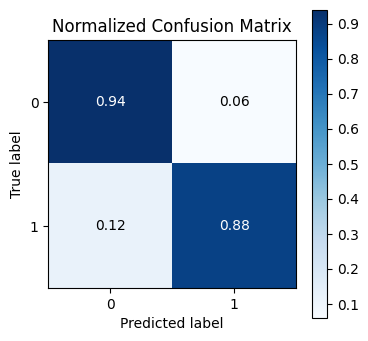

In [58]:
# Tuned KNeighborsClassifier For Validation

pipeline.set_params(Model = KNeighborsClassifier(**KNeighborsClassifierTuned.best_params))
pipeline.fit(X_train, y_train)
classifierListVal.append('KNeighborsClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1]
Balanced Accuracy 0.9444444444444444
Precision 0.8
Recall 1.0
ROC AUC score 0.9444444444444444
F1 score 0.888888888888889
MCC 0.8432740427115678
Validation score 0.9230769230769231
Confusion matrix
 [[16  2]
 [ 0  8]]


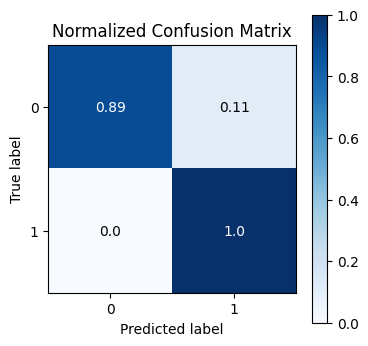

In [59]:
# GaussianProcessClassifier For Validation

pipeline.set_params(Model = GaussianProcessClassifier(random_state = seed, n_jobs=nJobs))
pipeline.fit(X_train, y_train)
classifierListVal.append('GaussianProcessClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned DecisionTreeClassifier For Validation

pipeline.set_params(Model = DecisionTreeClassifier(**DecisionTreeClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('DecisionTreeClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned GaussianNB For Validation

pipeline.set_params(Model = GaussianNB(**GaussianNBTuned.best_params))
pipeline.fit(X_train, y_train)
classifierListVal.append('GaussianNB')
y_pred = pipeline.predict(X_validation) # .predict(X)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned QuadraticDiscriminantAnalysis For Validation

pipeline.set_params(Model = QuadraticDiscriminantAnalysis(**QuadraticDiscriminantAnalysisTuned.best_params))
pipeline.fit(X_train, y_train)
classifierListVal.append('QuadraticDiscriminantAnalysis')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned LinearSVC For Validation

pipeline.set_params(Model = LinearSVC(**LinearSVCTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('LinearSVC')
y_pred = pipeline.predict(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned RidgeClassifier For Validation

pipeline.set_params(Model = RidgeClassifier(**RidgeClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('RidgeClassifier')
y_pred = pipeline.predict(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned SGDClassifier For Validation

pipeline.set_params(Model = SGDClassifier(**SGDClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('SGDClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned XGBClassifier For Validation

pipeline.set_params(Model = XGBClassifier(**XGBClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('XGBClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

### Make final pipeline for each seed and 'test' it on the testing dataset
* XGBClassifier for sarcoma sensitivity

In [ ]:
# Final pipeline

pipeline.set_params(Model = XGBClassifier(**XGBClassifierTuned.best_params, n_jobs=nJobs))

In [ ]:
# fit the pipeline

pipeline.fit(X, y)

In [902]:
# load test data from saved
dfTestFromDisk = pd.read_excel('dfTest_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')
df = dfTestFromDisk

In [903]:
# select features based on dfTrain's RFE

fileName = '_selectedFeaturesRFECV_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'r') as f:
    selected_featuresFromDisk = json.load(f)

colsToKeep = []
colsToKeep = copy.deepcopy(selected_featuresFromDisk)
colsToKeep.append(target)

df = df[colsToKeep]

In [905]:
# split into X and Y

X_test, y_test = X_y_split(df, target)


X shape: (10, 86)


10 Samples 


86 Attributes 



,HNRNPR,HPR,HPSE,HPX,HRG,HRNR,HSDL2,HSP90AA1,HSP90AB1,HSP90B1,HSPA1A,HSPA5,HSPA6,HSPA8,HTT,HYOU1,IBSP,IDH2,IGFALS,IGHG3,IGHG4,IGHV1-18,IGHV3-13,IGHV3-15,IGHV3-20,IGHV3-35,IGHV3-49,IGHV3-72,IGHV4-28,IGHV5-51,IGKC,IGKV1-16,IGKV1-17,IGKV1-33,IGKV1-5,IGKV2-24,IGKV3-20,IGKV4-1,INHBE,IQGAP2,ISOC1,ITM2B,ITPR1,JCHAIN,KGD4,MBP,MICAL1,MPP1,NFKB1,PKN1,PLXDC2,RASA1,RFTN1,RIPOR3,RNF121,ROCK2,RPLP1,RPLP2,RSU1,S100A4,SAA1,SAA2,SEPTIN11,SEPTIN2,SEPTIN6,SEPTIN7,SERPINA4,SERPINA6,SERPINB6,SERPINE1,SH3BGRL3,SH3GL1,SLC25A5,SLC2A1,SPP2,SPTA1,ST13,STAT5B,SYNRG,TFRC,TGFB1I1,THBS4,TIMP1,TIMP2,TKT,TLN2
0,1102700,17927800,537610.0,54012000,7777300,1265511,431740,1132990.0,928250,1477050,485188.0,1062450,261650.0,5198000,1229340.0,376202,783640.0,812550.0,1502570,13091000,11408900,361290.0,299110.0,174780.0,444130.0,190240,178790,273948.0,147400.0,1497460,159608000,240710.0,227000,1033300,821700,76354.0,1228500,4266690,275284.0,913410.0,365850,126920.0,39243,4910150,1662100.0,4626600,234651.0,811500,60947.0,334299,268096,2254700,224780,654590.0,8461900,587076,839326,1263300,5890230,219873.0,6565400,1545080.0,179552.0,604690.0,385727.0,709050,2121130,808600,396801,178146,633422,736950.0,166882.0,379196,48859000,783610,934150.0,263813.0,1359600.0,21818,5226000,1152980,50325.0,371920,499931.0,485050
1,1633140,12903200,735870.0,47108000,9058400,573660,1974050,468820.0,668330,1870680,113983.0,781430,NaN,2942000,797900.0,412870,894180.0,706680.0,1560620,21107700,2486156,152680.0,89821.0,175450.0,2031300.0,618540,459634,NaN,68498.0,1305260,161096000,NaN,111430,585736,2073600,NaN,2552612,1877860,97405.0,216232.0,2784690,242630.0,198980,7438100,NaN,4039500,163494.0,1268740,210417.0,324360,733130,620378,500110,1062443.0,365850,6465562,1290537,3497880,3129840,142820.0,4777780,556940.0,32367.0,320155.0,269704.0,491030,1643870,462620,543800,374086,150320,1301670.0,74456.0,984440,41544000,2046030,1508180.0,1393400.0,7313800.0,155024,8602300,2365660,123506.0,474180,1645800.0,827290
2,1188300,18561900,NaN,52207000,16656200,1802410,1699000,NaN,152619,1993280,NaN,487210,83980.0,1025060,NaN,105630,1560100.0,NaN,1206290,23948000,16008200,404380.0,NaN,39840.0,1429000.0,321340,277760,NaN,233840.0,1643710,369524000,23982.0,87229,513670,122090,NaN,385210,2677390,158127.0,NaN,1808040,NaN,411670,5055040,NaN,3430200,NaN,75882,NaN,81312,177240,1315631,951420,2687800.0,662900,1000580,636390,111490,1293715,NaN,3097900,NaN,750480.0,NaN,NaN,92038,2641210,572143,459050,944540,338730,NaN,NaN,1905489,73584000,2464790,NaN,NaN,12719000.0,52436,1797110,10896700,NaN,558230,1341600.0,263630
3,367960,14700200,2156090.0,40419000,9278300,1553340,1042580,944190.0,792880,5798000,445284.0,5668300,1142800.0,9961200,156190.0,1095300,395590.0,5434000.0,723610,37083000,27915800,373610.0,85671.0,212770.0,1060400.0,533420,682414,361738.0,337170.0,2406440,328546000,191042.0,199030,3253200,2535560,705860.0,1985600,4611010,135039.0,2180340.0,1235440,53129.0,446253,1724690,1447100.0,1811300,NaN,1364250,47583.0,80896,334361,845264,266310,93027.0,2032200,783380,522470,551170,4587300,63482.0,16616170,2687220.0,506140.0,1424290.0,1878090.0,1432530,692350,599390,411130,430050,1236663,768240.0,2450260.0,1156810,61286000,1653030,556780.0,97915.0,3072500.0,178004,3316470,1093660,585945.0,118918,NaN,258140
4,1602380,8187360,696380.0,70799000,8538700,876897,2342830,1692750.0,896370,2323850,759830.0,2547430,239070.0,7722100,146060.0,233964,NaN,2095110.0,1399030,30172900,20998300,384770.0,389760.0,628430.0,15963.0,922310,334031,540590.0,NaN,2948610,241053000,55297.0,314290,1063000,871120,3658900.0,2064619,5381438,1319950.0,1629920.0,717340,NaN,100080,4806700,479700.0,4429300,245584.0,1338250,NaN,49069,35739,2853450,33882,126425.0,4913800,994710,427800,760740,7260710,262003.0,15979890,2415130.0,342695.0,470450.0,1057120.0,890620,1222670,1914640,428710,653880,784300,1081370.0,762440.0,559656,30311600,1843740,592830.0,147636.0,NaN,55840,3949800,404920,208071.0,172606,121550.0,131240





y shape: (10,)


10 Samples 



0    S
1    S
2    S
3    S
4    R
Name: sensitivity, dtype: object

In [906]:
# label encode y, as above
y_test = pd.Series(le.fit_transform(y_test))

0    1
1    1
2    1
3    1
4    0
5    0
6    0
7    1
8    0
9    1
dtype: int64

In [908]:
# impute 0s, as above

imputeWideDFMinOr0(X_test)

quantType is Intensity_Raw


0

In [910]:
# impute any new proteins in X_test with the min value of the dataset, as above
genesWithNANs = X_test.columns[X_test.isna().any()].tolist()

X_test[genesWithNANs] = min(X_test.min())

[]

In [916]:
y_pred = pipeline.predict(X_test)

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [917]:
y_prob = pipeline.predict_proba(X_test)

array([[4.4860709e-01, 5.5139291e-01],
       [2.2952062e-01, 7.7047938e-01],
       [8.3521491e-01, 1.6478509e-01],
       [2.3738742e-03, 9.9762613e-01],
       [7.8916550e-05, 9.9992108e-01],
       [3.0276352e-01, 6.9723648e-01],
       [8.6963093e-01, 1.3036905e-01],
       [2.8118110e-01, 7.1881890e-01],
       [4.2102933e-03, 9.9578971e-01],
       [2.6153922e-03, 9.9738461e-01]], dtype=float32)

In [918]:
# re-format this output
y_prob = [i[1] for i in y_prob]

# append to lists
y_predList.append(y_pred)
y_testList.append(y_test)
y_probList.append(y_prob)
seedListStats.append(seed)
trainFracListStats.append(trainFrac)

## stats

In [921]:
print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision", sklearn.metrics.precision_score(y_test, y_pred))
print("Recall", sklearn.metrics.recall_score(y_test, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_test, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_test, y_pred))

s = pipeline.score(X_test, y_test)
print(f"Test score {s}")

Balanced Accuracy 0.5416666666666667
Precision 0.625
Recall 0.8333333333333334
ROC AUC score 0.5416666666666667
F1 score 0.7142857142857143
Test score 0.6


In [922]:
print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_test, y_pred))

Confusion matrix
 [[1 3]
 [1 5]]


In [ ]:
# plot normalized confusion matrix from the current seed
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,figsize=(2,2))
plt.show()

In [923]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections.abc import Iterable

def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item
             
cm = confusion_matrix(list(flatten(y_testList)), list(flatten(y_predList))) # for many trials

# for all models
from collections.abc import Iterable

cm = confusion_matrix(list(flatten(y_testList)), list(flatten(y_predList))) # for all models

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()

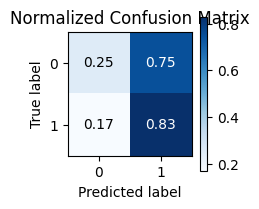

In [924]:
# plot normalized confusion matrix for all seeds/models in the current loop
skplt.metrics.plot_confusion_matrix(list(flatten(y_testList)), list(flatten(y_predList)), normalize=True,figsize=(2,2))
 
plt.show()

### Test stastistics

In [931]:
TN = cm[0][0]
FN = cm[1][0] # type II error
TP = cm[1][1]
FP = cm[0][1] # Type I error

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
precision = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# balanced accurcy
bACC = (TPR + TNR) / 2
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# F1 score
F1 = (2 * TP) / (2 * TP + FP + FN)
# False ommission rate
FOR = 1 - NPV
# LR+, positive liklihood ratio
LRpos = TPR / FPR
# LR-, negative liklihood ratio
LRneg = FNR / TNR
# diagnostic odds ratio
oddsRatio = LRpos/LRneg

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [932]:
print("the sensitivity/TPR is: " + str(TPR))
print("the specificity/TNR is: " + str(TNR))
print("the accuracy is: " + str(ACC))
print("the balanced accuracy is: " + str(bACC))
print("the negative predictive value (NPV) is " + str(NPV))
print("the diagnostic odds ratio is " + str(oddsRatio))
print("The positive LR is " + str(LRpos))
print("The negative LR is " + str(LRneg))
print("The F1 score is " + str(F1))

the sensitivity/TPR is: 0.8095238095238095
the specificity/TNR is: 0.6071428571428571
the accuracy is: 0.7285714285714285
the balanced accuracy is: 0.7083333333333333
the positive predictive value (PPV) aka precision is 0.7555555555555555
the negative predictive value (NPV) is 0.68
the diagnostic odds ratio is 6.568181818181818
The positive LR is 2.0606060606060606
The negative LR is 0.3137254901960784
The F1 score is 0.7816091954022989


### ROC curve

In [ ]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

In [ ]:
# calc the AUROC
partitions = 100

ROC = roc_from_scratch(y_prob, y_test, partitions=partitions) # y_prob[:,1]
fpr, tpr = ROC[:, 0], ROC[:, 1]
rectangle_roc = 0
for k in range(partitions):
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
print('The AUROC is: ' + str(rectangle_roc))

In [ ]:
# overlaid ROC
from sklearn.metrics import auc

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # regularly spaced points

#set up plotting area
plt.figure(figsize=(3, 3))
ax = plt.axes() # enables overlay

plt.plot([0, 1], [0, 1],'--', color = 'black', lw = 2)
plt.xlim([0, 1])
plt.ylim([0, 1])

fprList = []
tprList = []

for y_prob, y_test in zip(y_probList,y_testList):
    
    ROC = roc_from_scratch(np.reshape(y_prob,(-1)),y_test,partitions=100) # y_prob[:,1]
    plt.plot(ROC[:,0],ROC[:,1],color='black', alpha = 0.025)
    plt.title('ROC Curve',fontsize=12)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)

    sort = np.argsort(ROC[:,0])
    interp_tpr = np.interp(mean_fpr, ROC[:,0][sort], ROC[:,1][sort]) # interp needs to be sorted
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    rectangle_roc = 0
    for k in range(partitions):
        fpr, tpr = ROC[:, 0], ROC[:, 1]
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
    print('AUROC is ' + str(rectangle_roc))    
    aucs.append(rectangle_roc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve")

plt.plot()
ax.legend(bbox_to_anchor=(3.3, .5), loc='center right', borderaxespad=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [92]:
from itertools import chain
y_testListFlat = list(chain.from_iterable(y_testList)) 
y_predListFlat = list(chain.from_iterable(y_predList))
y_probListFlat = list(chain.from_iterable(y_probList))
y_1MinusProbListFlat = [1 - x for x in y_probListFlat]
y_predProbAFormattedLikeSKLearn = np.stack((y_1MinusProbListFlat, y_probListFlat), axis = 1)

In [934]:
# https://towardsdatascience.com/roc-curve-and-auc-from-scratch-in-numpy-visualized-2612bb9459ab

def true_false_positive(threshold_vector, y_test): # threshold_vector is input as y_prob
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr # ROC[:,0] is fpr, ROC[:,1] is tpr

def roc_from_scratch(probabilities, y_test, partitions=1000):
    roc = np.array([])
    for i in range(partitions + 1):
        
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

Text(0, 0.5, 'True Positive Rate')

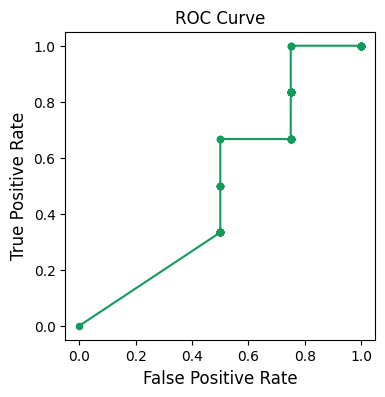

In [935]:
plt.figure(figsize=(4,4))

ROC = roc_from_scratch(y_prob,y_test,partitions=100)
plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=20)
plt.plot(ROC[:,0],ROC[:,1],color='#0F9D58')
plt.title('ROC Curve',fontsize=12)
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)

In [936]:
y_prob

[0.5513929,
 0.7704794,
 0.16478509,
 0.9976261,
 0.9999211,
 0.6972365,
 0.13036905,
 0.7188189,
 0.9957897,
 0.9973846]

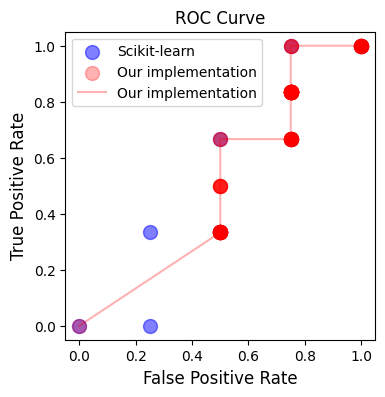

In [937]:
# another way (1 seed)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob) # y_prob[:,1]
#fpr, tpr, thresholds = roc_curve(y_test, y_prob) # way that usualy works

plt.figure(figsize=(4, 4))
plt.scatter(fpr, tpr, s=100, alpha=0.5, color="blue", label="Scikit-learn")
plt.scatter(ROC[:, 0], ROC[:, 1], color="red", s=100, alpha=0.3, label="Our implementation")
plt.plot(ROC[:, 0], ROC[:, 1], color="red", alpha=0.3, label="Our implementation")
plt.title("ROC Curve", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend()

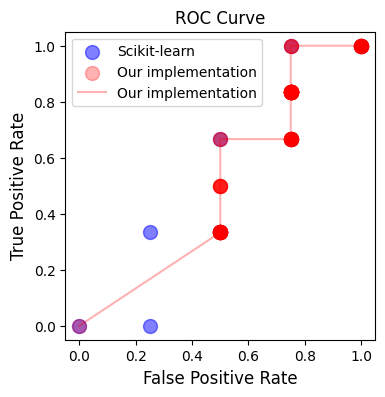

In [938]:
# another way (1 seed)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob) # y_prob[:,1]
#fpr, tpr, thresholds = roc_curve(y_test, y_prob) # way that usualy works

plt.figure(figsize=(4, 4))
plt.scatter(fpr, tpr, s=100, alpha=0.5, color="blue", label="Scikit-learn")
plt.scatter(ROC[:, 0], ROC[:, 1], color="red", s=100, alpha=0.3, label="Our implementation")
plt.plot(ROC[:, 0], ROC[:, 1], color="red", alpha=0.3, label="Our implementation")
plt.title("ROC Curve", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend()

In [939]:
# calc the AUROC of most recent seed
partitions = 1000

ROC = roc_from_scratch(y_prob, y_test, partitions=partitions) # y_prob[:,1]
#ROC = roc_from_scratch(y_prob, y_test, partitions=partitions) # way that usually works
fpr, tpr = ROC[:, 0], ROC[:, 1]
rectangle_roc = 0
for k in range(partitions):
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
print('The AUROC is: ' + str(rectangle_roc))

The AUROC is: 0.49999999999999994


In [940]:
# calc the AUROC of aggregated list
partitions = 1000

ROC = roc_from_scratch(y_probList, y_testList, partitions=partitions) # y_prob[:,1]
#ROC = roc_from_scratch(y_prob, y_test, partitions=partitions) # way that usually works
fpr, tpr = ROC[:, 0], ROC[:, 1]
rectangle_roc = 0
for k in range(partitions):
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
print('The AUROC is: ' + str(rectangle_roc))

The AUROC is: 0.6386054421768709


AUROC is 1.0
AUROC is 0.5
AUROC is 0.5833333333333333
AUROC is 0.8333333333333334
AUROC is 0.75
AUROC is 0.5833333333333334
AUROC is 0.49999999999999994


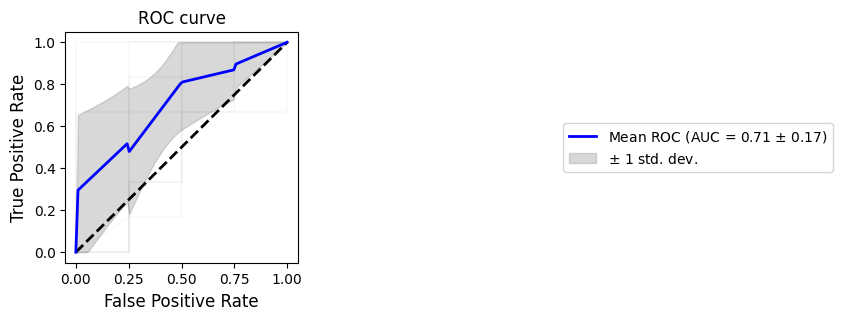

In [941]:
# overlaid ROC
from sklearn.metrics import auc

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # regularly spaced points

#set up plotting area
plt.figure(figsize=(3, 3))
ax = plt.axes() # enables overlay

plt.plot([0, 1], [0, 1],'--', color = 'black', lw = 2)
plt.xlim([0, 1])
plt.ylim([0, 1])

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fprList = []
tprList = []

for y_prob, y_test in zip(y_probList,y_testList):
    
    ROC = roc_from_scratch(np.reshape(y_prob,(-1)),y_test,partitions=1000) # y_prob[:,1]
    #ROC = roc_from_scratch(y_prob,y_test,partitions=100) # way that usually works

    #plt.scatter(ROC[:,0],ROC[:,1],color='black',s=20, alpha = 0.8)
    plt.plot(ROC[:,0],ROC[:,1],color='black', alpha = 0.025)
    plt.title('ROC Curve',fontsize=12)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    #print(ROC[:,1])

    sort = np.argsort(ROC[:,0])
    interp_tpr = np.interp(mean_fpr, ROC[:,0][sort], ROC[:,1][sort]) # interp needs to be sorted
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    rectangle_roc = 0
    for k in range(partitions):
        fpr, tpr = ROC[:, 0], ROC[:, 1]
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
    print('AUROC is ' + str(rectangle_roc))    
    aucs.append(rectangle_roc)

    #if auc < 0.5:
    #    probs = [-x for x in probs]

mean_tpr = np.mean(tprs, axis=0)
#print(mean_tpr)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

#print("mean_fpr is: " + str(mean_fpr)) # QC
#print("mean_tpr is: " + str(mean_tpr)) # QC

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=1)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve")

plt.plot()
ax.legend(bbox_to_anchor=(3.3, .5), loc='center right', borderaxespad=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('ROC_overlaid_' + target + '_quantType_' + quantType + '.pdf',format='pdf', dpi=500, bbox_inches='tight')# axis labels
plt.savefig('ROC_overlaid_' + target + '_quantType_' + quantType + '.svg',format='svg', dpi=500, bbox_inches='tight')# axis labels. Saves to Fugure2 folder currently

In [942]:
# testing to make line smoother


In [943]:
# in progress

from itertools import chain
y_testListFlat = list(chain.from_iterable(y_testList)) 
y_predListFlat = list(chain.from_iterable(y_predList))
#y_probListFlat = list(chain.from_iterable(y_probList)) # usually works
y_probListFlat = list(chain.from_iterable(y_probList)) # y_probList[:,1]
y_1MinusProbListFlat = [1 - x for x in y_probListFlat]
y_predProbAFormattedLikeSKLearn = np.stack((y_1MinusProbListFlat, y_probListFlat), axis = 1)

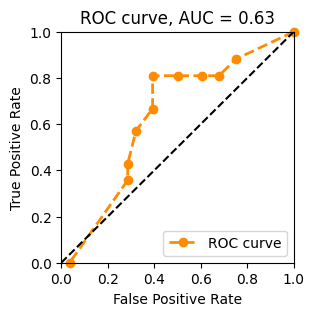

In [944]:
# Works

#plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (3,3)
%matplotlib inline

# false positive rate
FPR = []
# true positive rate
TPR = []
# Iterate thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.1)
# array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

# get number of positive and negative examples in the dataset
P = sum(y_testListFlat)
N = len(y_testListFlat) - P

# iterate through all thresholds and determine fraction of true positives
# and false positives found at this threshold
for thresh in thresholds:
    FP=0
    TP=0
    thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
    for i in range(len(y_probListFlat)):
        if (y_probListFlat[i] >= thresh):
            if y_testListFlat[i] == 1:
                TP = TP + 1
            if y_testListFlat[i] == 0:
                FP = FP + 1
    FPR.append(FP/N)
    TPR.append(TP/P)

# This is the AUC
#you're integrating from right to left. This flips the sign of the result
auc = -1 * np.trapz(TPR, FPR)

plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend(loc="lower right")
plt.savefig('AUC_example.png')
plt.show()

In [945]:
len(y_probList)

7

Bootstrap #1 ROC area: 0.634
Bootstrap #2 ROC area: 0.634
Bootstrap #3 ROC area: 0.634
Bootstrap #4 ROC area: 0.634
Bootstrap #5 ROC area: 0.634
Bootstrap #6 ROC area: 0.634
Bootstrap #7 ROC area: 0.634
Bootstrap #8 ROC area: 0.634
Bootstrap #9 ROC area: 0.634
Bootstrap #10 ROC area: 0.634
Bootstrap #11 ROC area: 0.634
Bootstrap #12 ROC area: 0.634
Bootstrap #13 ROC area: 0.634
Bootstrap #14 ROC area: 0.634
Bootstrap #15 ROC area: 0.634
Bootstrap #16 ROC area: 0.634
Bootstrap #17 ROC area: 0.634
Bootstrap #18 ROC area: 0.634
Bootstrap #19 ROC area: 0.634
Bootstrap #20 ROC area: 0.634
Bootstrap #21 ROC area: 0.634
Bootstrap #22 ROC area: 0.634
Bootstrap #23 ROC area: 0.634
Bootstrap #24 ROC area: 0.634
Bootstrap #25 ROC area: 0.634
Bootstrap #26 ROC area: 0.634
Bootstrap #27 ROC area: 0.634
Bootstrap #28 ROC area: 0.634
Bootstrap #29 ROC area: 0.634
Bootstrap #30 ROC area: 0.634
Bootstrap #31 ROC area: 0.634
Bootstrap #32 ROC area: 0.634
Bootstrap #33 ROC area: 0.634
Bootstrap #34 ROC a

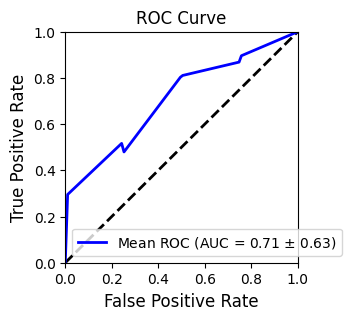

In [946]:
# testing

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_testListFlat, y_probListFlat) # y_prob[:,1]
#fpr, tpr, thresholds = roc_curve(y_test, y_prob) # way that usualy works

# confidence intervals

n_bootstraps = 1000
rng_seed = 1  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_predListFlat), len(y_predListFlat))
    if len(np.unique(y_testListFlat)) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_testListFlat, y_probListFlat)
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

# To get a confidence interval one can sort the samples:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

#set up plotting area
plt.figure(figsize=(3, 3))
ax = plt.axes() # enables overlay

plt.plot([0, 1], [0, 1],'--', color = 'black', lw = 2)
plt.xlim([0, 1])
plt.ylim([0, 1])

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, confidence_lower),
        lw=2, alpha=1)

#std_tpr = np.std(tprs, axis=0)
#tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
#                label=r'$\pm$ 1 std. dev.')

#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#       title="ROC curve")


#plt.figure(figsize=(4, 4))
#plt.scatter(fpr, tpr, s=100, alpha=0.5, color="blue", label="Scikit-learn")
plt.title("ROC Curve", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend()

In [947]:
 #testing

fpr, tpr, thresholds = roc_curve(y_testListFlat, y_probListFlat) # y_prob[:,1]

c_fill      = 'rgba(52, 152, 219, 0.2)'
c_line      = 'rgba(52, 152, 219, 0.5)'
c_line_main = 'rgba(41, 128, 185, 1.0)'
c_grid      = 'rgba(189, 195, 199, 0.5)'
c_annot     = 'rgba(149, 165, 166, 0.5)'
c_highlight = 'rgba(192, 57, 43, 1.0)'
fpr_mean    = np.linspace(0, 1, 100)
interp_tprs = []
for i in range(100):
    fpr           = fpr[i]
    tpr           = tpr[i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = 2*np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_lower,
        fill       = 'tonexty',
        fillcolor  = c_fill,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=2),
        hoverinfo  = "skip",
        showlegend = True,
        name       = f'AUC: {auc:.3f}')
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template    = 'plotly_white', 
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 800,
    height      = 800,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black')
fig.update_xaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black')

ValueError: object of too small depth for desired array

In [ ]:
# non-customizable ROC plot using scikitplot: based on https://scikit-plot.readthedocs.io/en/stable/metrics.html
# X_test and y_test are going to be the final ones from the train_test split, just FYI

# plot the whole combined list of values and predictions
plt_ = skplt.metrics.plot_roc(y_testListFlat, y_predProbAFormattedLikeSKLearn, # way that usually works
#                             figsize=(3, 3),
                             #plot_micro = False,
                             #plot_macro = False,
#                             cmap='Dark2', #Dark2, tab10
                            ) 

#plt_.legend(bbox_to_anchor=(2.45, .55), loc='center right', borderaxespad=0)
#plt_.figure.savefig('ROC_overlaid_scikitplot_TestSizes' + str(testSizes) + '.pdf',format='pdf', dpi=500, bbox_inches='tight')
#plt_.figure.savefig('ROC_overlaid_scikitplot_TestSizes' + str(testSizes) + '.svg',format='svg', dpi=500, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()

# predict on the test data using the single-objective Auto-sklearn & plot perf
single_objective_precision = sklearn.metrics.precision_score(y_test, y_pred)
single_objective_recall = sklearn.metrics.recall_score(y_test, y_pred)

ax.scatter(single_objective_precision, single_objective_recall, label= "Pipeline")

# Label the plot
_ = ax.set_xlabel("Precision / Positive Predictive Value")
_ = ax.set_ylabel("True Positive Rate / Recall")
_ = ax.set_xlim((0, 1))
_ = ax.set_ylim((0, 1))
_ = ax.legend(bbox_to_anchor=(1.75, .95), loc='center right', borderaxespad=0)
_ = ax.set_title("Test performances of all models found by Auto-sklearn2")

### save final lists

In [949]:
# save final classification lists to disk
import pickle

# save y_predList
fileName = 'y_predList_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(y_predList, fp)

# reload y_predList
with open(fileName, "rb") as fp:   # Unpickling
    y_predList = pickle.load(fp)



# save y_probList
fileName = 'y_probList_target-' + target + '_quantType_' + quantType + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(y_probList, fp)

# reload y_probList
with open(fileName, "rb") as fp:   # Unpickling
    y_probList = pickle.load(fp)



# save y_testList
fileName = 'y_testList_target-' + target + '_quantType_' + quantType + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(y_testList, fp)

# reload y_probList
with open(fileName, "rb") as fp:   # Unpickling
    y_testList = pickle.load(fp)


# save finalImportancesMeanList
fileName = 'finalImportancesMeanList_target-' + target + '_quantType_' + quantType + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(finalImportancesMeanList, fp)

# reload finalImportancesMeanList
with open(fileName, "rb") as fp:   # Unpickling
    finalImportancesMeanList = pickle.load(fp)
    

# save finalFeaturesList
fileName = 'finalFeaturesList_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(finalFeaturesList, fp)

# reload finalFeaturesList
with open(fileName, "rb") as fp:   # Unpickling
    finalFeaturesList = pickle.load(fp)